<a href="https://colab.research.google.com/github/Ademola-Olorunnisola/Ademola-Olorunnisola.github.io/blob/main/Ademola_EKF_UKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [2]:

try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 5.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-i_gixdtp
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-i_gixdtp
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=9a70674d3d7286e05476c3f95a0a1d756ac40cc139fe781d930f59ad06e831dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ra5tkqx/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


In [3]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/Ademola-Olorunnisola/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

tb_simulations = import_local_or_github('tb_simulations', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')
unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Dynamics and measurement functions

In [4]:
# all three measurement functions can be accessed from the planar drone script:
h_a = tb_simulations.H('h_ivr').h
h_b = tb_simulations.H('h_all_svir').h


In [5]:
f = tb_simulations.F().f
h = h_a # choose one of the measurement functions

In [6]:
h(None, None, return_measurement_names=True)

['I_absolute', 'V_absolute', 'R_absolute']

# Run MPC simulation

In [7]:

t_sim, x_sim, u_sim, y_sim, simulator = tb_simulations.simulate_tb(
    f,
    h,
    tsim_length=365,
    dt=1.0
)

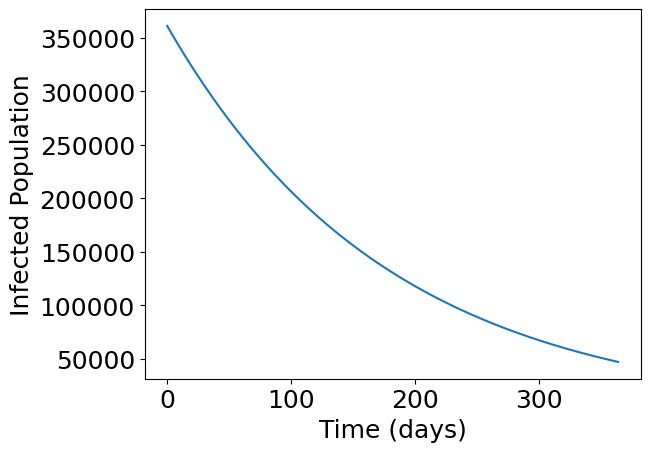

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_sim, x_sim['I'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Infected Population')
plt.show()

# Simulate noisy measurements

In [50]:
measurement_noise_stds = {
    'I_absolute': 2000,
    'V_absolute': 0.0009,
    'R_absolute': 5000
}

In [52]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}

<Axes: xlabel='Time', ylabel='V_absolute'>

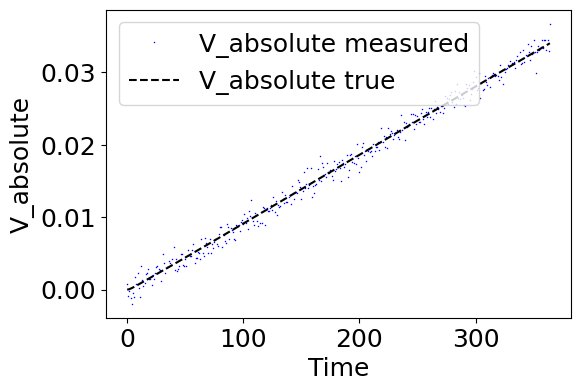

In [49]:
plot_tme(t_sim, y_sim['V_absolute'], y_noisy['V_absolute'], label_var='V_absolute')

<Axes: xlabel='Time', ylabel='I_absolute'>

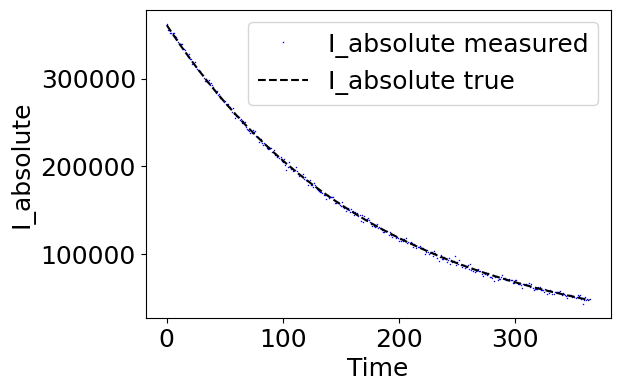

In [53]:
plot_tme(t_sim, y_sim['I_absolute'], y_noisy['I_absolute'], label_var='I_absolute')

<Axes: xlabel='Time', ylabel='R_absolute'>

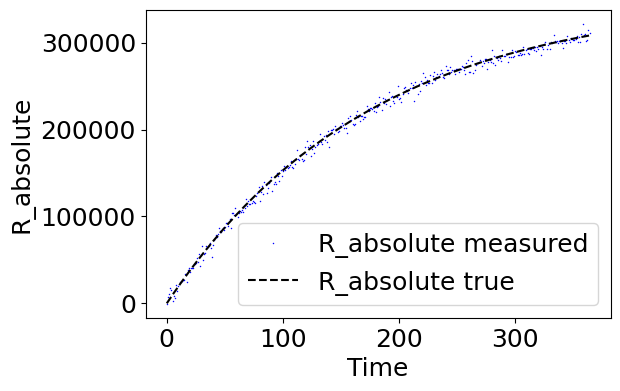

In [54]:
plot_tme(t_sim, y_sim['R_absolute'], y_noisy['R_absolute'], label_var='R_absolute')

### Save data as dataframes

In [12]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

# Kalman filter parameters and initilization

In [15]:
N = 223000000
x0 = np.array([
    (N - 158330000 - 361000 - 12000000),  # S
    158330000,                             # V
    361000,                                # I
    12000000,                              # R
    0.3,                                   # beta
    0.8                                    # sigma
])

In [16]:
x0

array([5.2309e+07, 1.5833e+08, 3.6100e+05, 1.2000e+07, 3.0000e-01,
       8.0000e-01])

In [59]:
# Get the first control input from simulation
u0 = np.array([u_sim['alpha'][0], u_sim['kappa'][0]])
P0 = np.eye(6) * 1e10

In [60]:
Q = np.diag([1e8]*4 + [1e-6]*2)
R = np.diag(list(measurement_noise_stds.values()))**2

In [61]:

dt = np.mean(np.diff(t_sim))

# Extended Kalman Filter

In [63]:
EKF = extended_kalman_filter.EKF(
    f, h, x0, u0, P0, Q, R,
    dynamics_type='continuous',
    discretization_timestep=dt,
    circular_measurements=(0, 0, 0, 0, 0, 0)
)

In [64]:
EKF.estimate(y_noisy_df, u_sim_df)

/content/tb_simulations.py:62: RuntimeWarning: overflow encountered in scalar multiply
  f0_contribution = np.array([Lambda - beta * S * I - mu * S,
/content/tb_simulations.py:63: RuntimeWarning: overflow encountered in scalar multiply
  -sigma * beta * V * I - mu * V,
/content/tb_simulations.py:64: RuntimeWarning: overflow encountered in scalar multiply
  beta*S*I + sigma*beta*V*I - gamma*I - mu*I,
/content/tb_simulations.py:79: RuntimeWarning: overflow encountered in scalar multiply
  f2_contribution = kappa * np.array([beta*S*I,
/content/tb_simulations.py:80: RuntimeWarning: overflow encountered in scalar multiply
  sigma*beta*V*I,
/content/tb_simulations.py:81: RuntimeWarning: overflow encountered in scalar multiply
  -beta*S*I - sigma*beta*V*I,
/content/tb_simulations.py:87: RuntimeWarning: invalid value encountered in add
  x_dot_vec = f0_contribution + f1_contribution + f2_contribution


LinAlgError: Array must not contain infs or NaNs